# Attribute

**Direct Reference** PINN Repository from Jay Roxis

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Additional Dervative work**: Ben Moseley, PINNs: an introductory crash course

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

# Libraries and Dependencies

In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import warnings
import time
from scipy.integrate import odeint
import pandas as pd

warnings.filterwarnings('ignore')

**Check device availability**

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Class for generating dense deep network architecture

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### Physics Informed Neural Network Class

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, t_data, t_physics, X, N, layers):
        
        # data
        self.X = torch.tensor(X, requires_grad=True).float().to(device)
        self.S, self.I, self.R, self.D = self.X
        self.t_data = torch.tensor(t_data, requires_grad=True).float().to(device)
        self.t_physics = torch.tensor(t_physics, requires_grad=True).float().to(device)
        self.N = N
        
        # initialize unkown model parameter(s)
        self.beta_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        self.gamma_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        self.mu_param = torch.nn.Parameter(torch.rand(1, requires_grad=True).to(device))
        

        # deep neural network
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('gamma', self.gamma_param)
        self.dnn.register_parameter('beta', self.beta_param)
        self.dnn.register_parameter('mu', self.mu_param)

        # Define coefficients to tune loss component weights
        self.res_comp_scale = 1.0
        self.res_pop_scale = 0.0001
        self.data_scale = 1.0
        self.IC_scale = 0.0#1.0

        #Compartment ICs
        #optional compartment IC
        self.S_init = torch.tensor(self.S[0], requires_grad=True).float().to(device)
        self.I_init = torch.tensor(self.I[0], requires_grad=True).float().to(device)
        self.R_init = torch.tensor(self.R[0], requires_grad=True).float().to(device)
        self.D_init = torch.tensor(self.D[0], requires_grad=True).float().to(device)
        self.t_init = torch.tensor([[0.]], requires_grad=True).float().to(device)

        # store separate losses for visualization (per epoch)
        self.losses = []
        self.datalosses = []
        self.residlosses = []
        self.Nlosses = []
        self.IClosses = []
        self.betas = [] #track progress of 'beta'
        self.gammas = [] #track progress of 'gamma'
        self.mus = [] #track progress of 'mu'

         # optimizers: using the same settings
        l_r = 5e-4
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = l_r)
        self.iter = 0
        #self.adam_schedule = torch.optim.lr_scheduler.CyclicLR(self.optimizer_Adam, base_lr=1e-6, \
        #    max_lr=5e-4, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)
        
    #force parameters to be in a range
    @property
    def beta(self):
        return torch.tanh(abs(self.beta_param))

    @property
    def gamma(self):
        return torch.tanh(abs(self.gamma_param))

    @property
    def mu(self):
        return torch.tanh(abs(self.mu_param))
    
    def net_x(self, t):  
        out = self.dnn(t)
        S = torch.reshape(out[:,0], (len(t), 1))
        I = torch.reshape(out[:,1], (len(t), 1))
        D = torch.reshape(out[:,2], (len(t), 1))
        R = torch.reshape(out[:,3], (len(t), 1))
        return S, I, D, R
    
    def net_f(self, t):
        """ The pytorch autograd version of calculating residual """       
        snet, inet, dnet, rnet = self.net_x(t)

        snet_t = torch.autograd.grad(
            snet, t, 
            grad_outputs=torch.ones_like(snet),
            create_graph=True,
        )[0]
        inet_t = torch.autograd.grad(
            inet, t, 
            grad_outputs=torch.ones_like(inet),
            create_graph=True,
        )[0]
        dnet_t = torch.autograd.grad(
            dnet, t, 
            grad_outputs=torch.ones_like(dnet),
            create_graph=True,
        )[0]
        rnet_t = torch.autograd.grad(
            rnet, t, 
            grad_outputs=torch.ones_like(rnet),
            create_graph=True,
        )[0]

        s_res = snet_t + (self.beta / self.N)*snet*inet
        i_res = inet_t -  (self.beta / self.N)*snet*inet + self.gamma*inet + self.mu*inet
        d_res = dnet_t - self.mu*inet
        r_res = rnet_t - self.gamma*inet
        N_res = self.N - snet - inet - dnet - rnet
        return s_res, i_res, d_res, r_res, N_res
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter+1):
            s_pred, i_pred, d_pred, r_pred = self.net_x(self.t_data)
            s_init, i_init, d_init, r_init = self.net_x(self.t_init) #Initial conditions from network
            s_res_pred, i_res_pred, d_res_pred, r_res_pred, N_res_pred = self.net_f(self.t_physics)

            loss_data = (torch.mean(torch.square(self.S - s_pred)) +
                        torch.mean(torch.square(self.I - i_pred)) + 
                        torch.mean(torch.square(self.D - d_pred)) +
                        torch.mean(torch.square(self.R - r_pred)))
            loss_resid = (torch.mean(torch.square(s_res_pred)) +
                        torch.mean(torch.square(i_res_pred)) + 
                        torch.mean(torch.square(d_res_pred)) +
                        torch.mean(torch.square(r_res_pred)))
            loss_N =  torch.mean(torch.square(N_res_pred))
            loss_init = (torch.mean(torch.square(r_init - self.R_init)) +
                        torch.mean(torch.square(i_init - self.I_init)) +
                        torch.mean(torch.square(d_init - self.D_init)) +          
                        torch.mean(torch.square(s_init - self.S_init)))
            loss = self.res_comp_scale*loss_resid + self.data_scale*loss_data + self.res_pop_scale*loss_N + self.IC_scale*loss_init

            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            #self.adam_schedule.step()
            self.betas.append(self.beta.item())
            self.gammas.append(self.gamma.item())
            self.mus.append(self.mu.item())

            if epoch % 100 == 0:
                self.losses.append(loss.item())
                self.residlosses.append(self.res_comp_scale*loss_resid.item())
                self.datalosses.append(self.data_scale*loss_data.item())
                self.IClosses.append(self.IC_scale*loss_init.item())
                self.Nlosses.append(self.res_pop_scale*loss_N.item())
                print(
                    'It: %d, Loss: %.5f, beta: %.5f, gamma: %.3f, mu: %.3f ' % 
                    (
                        epoch, 
                        loss.item(),
                        self.beta.item(),
                        self.gamma.item(),
                        self.mu.item()
                    )
                )
    
    def predict(self, t):
        self.dnn.eval()
        #net_x is 'predicted' based off of what is given
        s, i, d, r = self.net_x(t)
        s = s.detach().cpu().numpy()
        i = i.detach().cpu().numpy()
        d = d.detach().cpu().numpy()
        r = r.detach().cpu().numpy()

        return s, i, d, r

### Import Data

In [5]:
data = pd.read_csv('data/SIRD_organized_data.csv')
datanp = data.to_numpy()
# Total Ontario Population via Statcan (2020 estimate)
N = 14761811
#212 data points
S = datanp[:,1:2].astype('float64')
I = datanp[:,2:3].astype('float64')
R = datanp[:,3:4].astype('float64')
D = datanp[:,4:5].astype('float64')
# Normalize relative to static population estimate
Snorm = S/N
Inorm = I/N
Rnorm = R/N
Dnorm = D/N
#create a vector for time
t = np.linspace(0,211,212)
t = np.reshape(t,(212,1))
Ynorm = Snorm, Inorm, Rnorm, Dnorm
Y = S, I, R, D
duration = 211


### Plot Synthetic Data

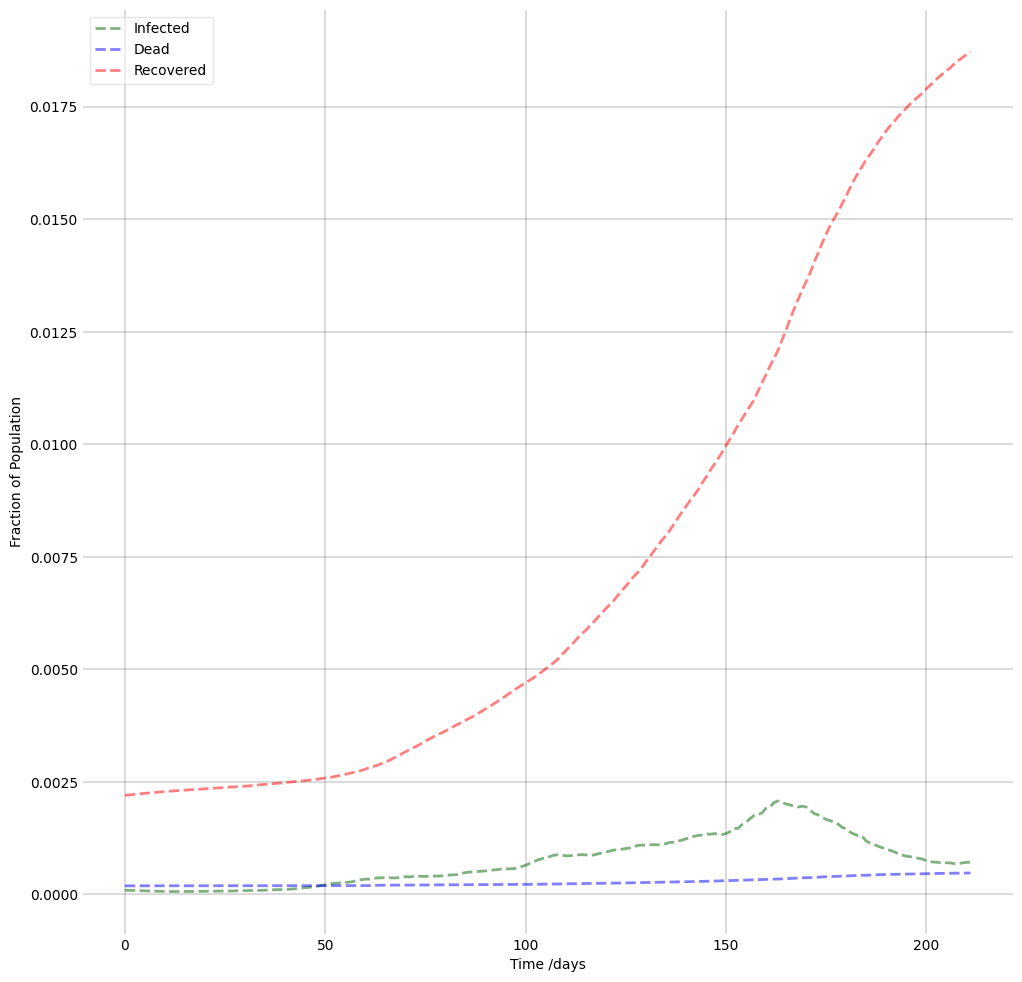

In [22]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

#ax.plot(t, Snorm, 'violet', alpha=0.5, lw=2, label='Susceptible', linestyle='dashed')
ax.plot(t, Inorm, 'darkgreen', alpha=0.5, lw=2, label='Infected', linestyle='dashed')
ax.plot(t, Dnorm, 'blue', alpha=0.5, lw=2, label='Dead', linestyle='dashed')
ax.plot(t, Rnorm, 'red', alpha=0.5, lw=2, label='Recovered', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Fraction of Population')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-') #plotting error
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

### Training

In [23]:
# network configuration
layers = [1, 32, 32, 32, 32, 32, 32, 32, 32, 4]
# line up physics mesh to align with baseline
timesteps_phys = 1000
t_phys = np.linspace(0,duration,timesteps_phys)
t_phys = np.transpose(t_phys)
t_phys = np.reshape(t_phys, (len(t_phys),1))
model = PhysicsInformedNN(t, t_phys, Ynorm, 1, layers)

#check number of params
total_params = sum(p.numel() for p in model.dnn.parameters())
print(total_params)

model.train(60000)

7591
It: 0, Loss: 0.68945, beta: 0.58995, gamma: 0.567, mu: 0.687 
It: 100, Loss: 0.00029, beta: 0.59759, gamma: 0.560, mu: 0.681 
It: 200, Loss: 0.00021, beta: 0.59840, gamma: 0.560, mu: 0.681 
It: 300, Loss: 0.00016, beta: 0.59907, gamma: 0.560, mu: 0.681 
It: 400, Loss: 0.00013, beta: 0.59958, gamma: 0.560, mu: 0.681 
It: 500, Loss: 0.00011, beta: 0.59996, gamma: 0.560, mu: 0.681 
It: 600, Loss: 0.00010, beta: 0.60022, gamma: 0.560, mu: 0.681 
It: 700, Loss: 0.00009, beta: 0.60038, gamma: 0.560, mu: 0.681 
It: 800, Loss: 0.00008, beta: 0.60045, gamma: 0.560, mu: 0.681 
It: 900, Loss: 0.00008, beta: 0.60043, gamma: 0.560, mu: 0.681 
It: 1000, Loss: 0.00008, beta: 0.60035, gamma: 0.560, mu: 0.681 
It: 1100, Loss: 0.00007, beta: 0.60020, gamma: 0.560, mu: 0.681 
It: 1200, Loss: 0.00006, beta: 0.60001, gamma: 0.560, mu: 0.681 
It: 1300, Loss: 0.00005, beta: 0.59982, gamma: 0.560, mu: 0.681 
It: 1400, Loss: 0.00004, beta: 0.59963, gamma: 0.560, mu: 0.681 
It: 1500, Loss: 0.00003, beta: 0

### Results Visualizations

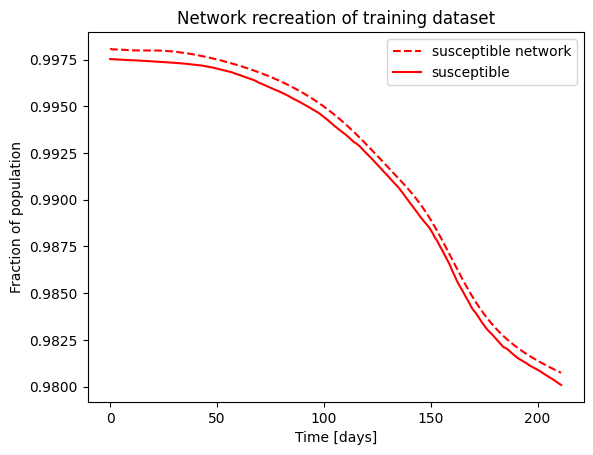

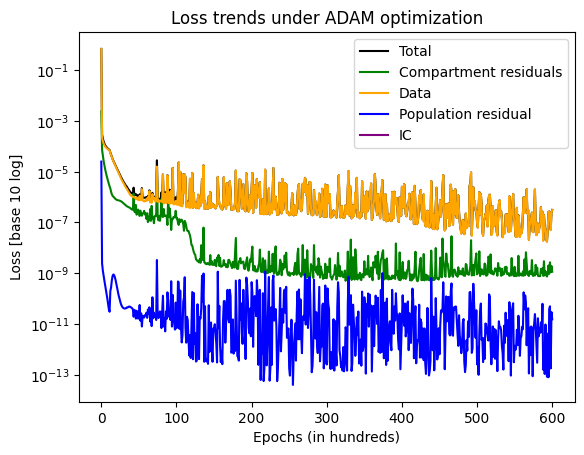

Adam final losses
Loss:  3.1253e-07, Residuals loss: 1.1424e-09, Data loss: 3.1137e-07, Pop Conservation loss: 1.5330e-11, IC Loss: 0.0000e+00
Estimated beta value
0.10618744790554047
Estimated gamma value
0.10232173651456833
Estimated mu value
0.00200233468785882


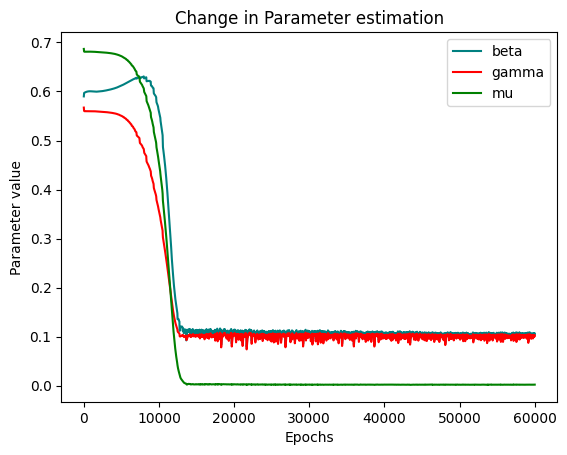

In [30]:
#plot true result comparison to network output
t_inter = np.linspace(0,211,1000)
t_inter = np.transpose(t_inter)
t_inter = np.reshape(t_inter, (len(t_inter),1))
ttensor = torch.tensor(t_inter).float().to(device)
[snet, inet, dnet, rnet] = model.predict(ttensor)
plt.plot(t_inter, snet, color = 'red', label = 'susceptible network', linestyle = 'dashed')
plt.plot(t, Snorm, color = 'red', label = 'susceptible')
'''
plt.plot(t_inter, inet, color = 'blue', label = 'infected network', linestyle = 'dashed')
plt.plot(t, Inorm, color = 'blue', label = 'infected')
plt.plot(t_inter, dnet, color = 'black', label = 'dead network', linestyle = 'dashed')
plt.plot(t, Dnorm, color = 'black', label = 'dead')
plt.plot(t_inter, rnet, color = 'green', label = 'recovered network', linestyle = 'dashed')
plt.plot(t, Rnorm, color = 'green', label = 'recovered')
'''
plt.legend()
plt.title('Network recreation of training dataset')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.show()

#Plot Noisy Loss (ADAM)
plt.plot(model.losses[0:],color = 'black', label = "Total")
plt.plot(model.residlosses[0:],color = 'green', label = "Compartment residuals")
plt.plot(model.datalosses[0:],color = 'orange', label = "Data")
plt.plot(model.Nlosses[0:], color = 'blue', label = "Population residual")
plt.plot(model.IClosses[0:],color = 'purple', label = "IC")
plt.legend()
plt.yscale("log")
plt.title("Loss trends under ADAM optimization")
plt.xlabel('Epochs (in hundreds)')
plt.ylabel('Loss [base 10 log]')
plt.show()
# Print final loss components
print('Adam final losses')
print('Loss:  %.4e, Residuals loss: %.4e, Data loss: %.4e, Pop Conservation loss: %.4e, IC Loss: %.4e' % 
        (
            model.losses[-1],
            model.residlosses[-1],
            model.datalosses[-1],
            model.Nlosses[-1],
            model.IClosses[-1]
        )
    )


print('Estimated beta value')
print(model.beta.item())

print('Estimated gamma value')
print(model.gamma.item())

print('Estimated mu value')
print(model.mu.item())

# plot the learned SIRD parameters vs true SIRD parameters
plt.plot(model.betas[0:], color = 'teal', label ="beta")
plt.plot(model.gammas[0:], color = 'red', label="gamma")
plt.plot(model.mus[0:], color = 'green', label="mu")
plt.legend()
plt.title('Change in Parameter estimation')
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
plt.show()

Compare parameter estimates data via constructing the SIRD model

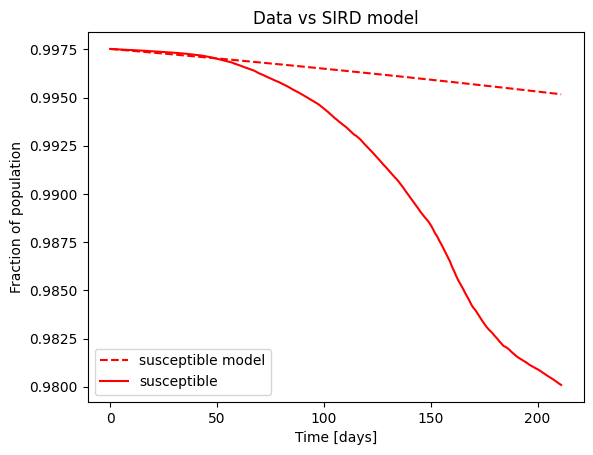

In [ ]:
def compartmentaldiff(y, t, beta, gamma, mu):
    S, I, R, D = y
    Sdot = - (beta) * S * I
    Idot = (beta) * S * I - gamma * I - mu * I
    Rdot = gamma * I
    Ddot = mu * I

    return Sdot, Idot, Rdot, Ddot

beta = model.beta.item()
gamma = model.gamma.item()
mu = model.mu.item()

Snorm0 = Snorm[0,0]
Inorm0 = Inorm[0,0]
Rnorm0 = Rnorm[0,0]
Dnorm0 = Dnorm[0,0]
tee = np.reshape(t_phys, (1000))
y0 = Snorm0, Inorm0, Rnorm0, Dnorm0
ret = odeint(compartmentaldiff, y0, tee, args=(beta, gamma, mu))
Smod, Imod, Rmod, Dmod = ret.T

# Plot data against parameter estimation
plt.plot(tee, Smod, color = 'red', label = 'susceptible model', linestyle = 'dashed')
plt.plot(t, Snorm, color = 'red', label = 'susceptible')
'''
plt.plot(tee, Imod, color = 'blue', label = 'infected model', linestyle = 'dashed')
plt.plot(t, Inorm, color = 'blue', label = 'infected')
plt.plot(tee, Dmod, color = 'black', label = 'dead model', linestyle = 'dashed')
plt.plot(t, Dnorm, color = 'black', label = 'dead')
plt.plot(tee, Rmod, color = 'green', label = 'recovered model', linestyle = 'dashed')
plt.plot(t, Rnorm, color = 'green', label = 'recovered')
'''
plt.legend()
plt.title('Data vs SIRD model')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.show()